In [1]:
import pandas as pd
from model.featurisation import smiles2graph 
from model.CL_model_vas_info import GNNModelWithNewLoss
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/freesolv.csv')
df.head()

,smiles,freesolv
0,CN(C)C(=O)c1ccc(cc1)OC,-11.01
1,CS(=O)(=O)Cl,-4.87
2,CC(C)C=C,1.83
3,CCc1cnccn1,-5.45
4,CCCCCCCO,-4.21


In [3]:
smiles_list = df["smiles"].tolist()
y = df['freesolv'].tolist()
data_list = smiles2graph(
    smiles_list,
    y
)
data_list[0]

Data(x=[13, 79], edge_index=[2, 26], edge_attr=[26, 10], global_features=[5], smiles='CN(C)C(=O)c1ccc(cc1)OC', y=[1, 1])

In [4]:
def load_model_embeddings(data_list, model_dir):
    model_embeddings = []
    for i in range(3):
        model_path = os.path.join(model_dir, str(i), "best_model.pth")

        # Instantiate model with shape matching input data
        model = GNNModelWithNewLoss(
            num_node_features=data_list[0].x.shape[1],
            num_edge_features=data_list[0].edge_attr.shape[1],
            num_global_features=data_list[0].global_features.shape[0],
            hidden_dim=128
        )

        state_dict = torch.load(model_path, map_location=torch.device("cpu"))
        model.load_state_dict(state_dict['encoder_state_dict'])
        model.eval()

        embeddings = []
        with torch.no_grad():
            for data in data_list:
                emb = model.forward(data.to(torch.device("cpu")))  
                embeddings.append(emb)
        model_embeddings.append(torch.stack(embeddings))
    return model_embeddings

In [5]:
def prepare_dataset(smiles2graph_fn, csv_file, model_dir):
    df = pd.read_csv(csv_file)
    smiles_list = df["smiles"].tolist()
    y = torch.tensor(df["freesolv"].values, dtype=torch.float32)
    data_list = smiles2graph_fn(smiles_list, y)
    embeddings = load_model_embeddings(data_list, model_dir)
    return embeddings, y

In [6]:
embeddings, y_tensor = prepare_dataset(smiles2graph, "data/freesolv.csv", "models")


c:\Users\chenxinyi\Documents\GitHub\clean_multi_cl\model\featurisation.py:216: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_val, dtype=torch.float).view(1, -1)
C:\Users\chenxinyi\AppData\Local\Temp\ipykernel_30544\3662369342.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are exp

In [7]:
embeddings = torch.stack(embeddings, dim=0)
embeddings = embeddings.squeeze(2)
embeddings = embeddings.permute(1, 0, 2)
embeddings.shape

torch.Size([642, 3, 128])

In [8]:
y_tensor.shape

torch.Size([642])

In [9]:
N = embeddings.size(0)
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size
generator  = torch.Generator().manual_seed(42)
full_ds = torch.utils.data.TensorDataset(embeddings, y_tensor)
train_ds, val_ds, test_ds = random_split(full_ds, [train_size, val_size, test_size], generator=generator)

In [10]:
class MolDataset(Dataset):
    def __init__(self, embeddings, targets):
        self.X = torch.from_numpy(embeddings).float()
        self.y = torch.from_numpy(targets).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=32,
    num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=32,
    num_workers=2, pin_memory=True
)

In [11]:
class TransformerFusionModel(nn.Module):
    def __init__(self, emb_dim, hidden_dim=64):
        super().__init__()
        self.k_proj = nn.Linear(emb_dim, emb_dim)
        self.v_proj = nn.Linear(emb_dim, emb_dim)
        self.query  = nn.Parameter(torch.randn(emb_dim))
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        B, N, D = x.size()
        K = self.k_proj(x)
        V = self.v_proj(x)
        Q = self.query.unsqueeze(0).unsqueeze(1).expand(B, 1, D)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(D)
        weights = torch.softmax(scores, dim=-1)
        fused = torch.matmul(weights, V).squeeze(1)
        out = self.mlp(fused).squeeze(-1)
        return out, weights.squeeze(1)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim   = embeddings.shape[-1]
model     = TransformerFusionModel(emb_dim=emb_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 300
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    total_train = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * xb.size(0)
    train_losses.append((total_train / len(train_ds))**0.5)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            preds, _ = model(xb)
            total_val += criterion(preds, yb).item() * xb.size(0)
    val_losses.append((total_val / len(val_ds))**0.5)
    print(f"Epoch {epoch}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/300 — Train Loss: 5.5236, Val Loss: 5.3822
Epoch 2/300 — Train Loss: 5.4698, Val Loss: 5.3196
Epoch 3/300 — Train Loss: 5.3747, Val Loss: 5.1839
Epoch 4/300 — Train Loss: 5.1744, Val Loss: 4.9096
Epoch 5/300 — Train Loss: 4.7522, Val Loss: 4.3978
Epoch 6/300 — Train Loss: 4.1993, Val Loss: 3.9121
Epoch 7/300 — Train Loss: 3.7662, Val Loss: 3.8006
Epoch 8/300 — Train Loss: 3.6789, Val Loss: 3.7468
Epoch 9/300 — Train Loss: 3.6567, Val Loss: 3.6915
Epoch 10/300 — Train Loss: 3.5654, Val Loss: 3.6201
Epoch 11/300 — Train Loss: 3.5531, Val Loss: 3.5551
Epoch 12/300 — Train Loss: 3.4938, Val Loss: 3.4878
Epoch 13/300 — Train Loss: 3.4359, Val Loss: 3.4169
Epoch 14/300 — Train Loss: 3.3663, Val Loss: 3.3459
Epoch 15/300 — Train Loss: 3.2088, Val Loss: 3.2711
Epoch 16/300 — Train Loss: 3.2027, Val Loss: 3.2094
Epoch 17/300 — Train Loss: 3.1203, Val Loss: 3.1493
Epoch 18/300 — Train Loss: 3.1829, Val Loss: 3.0943
Epoch 19/300 — Train Loss: 3.0142, Val Loss: 3.0429
Epoch 20/300 — Train 

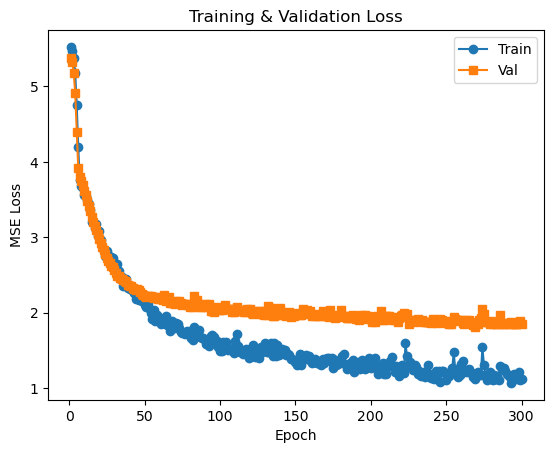

Test Loss: 1.8606
Test Loss: 1.5906
Test Loss: 1.5625
Test Loss: 1.5575


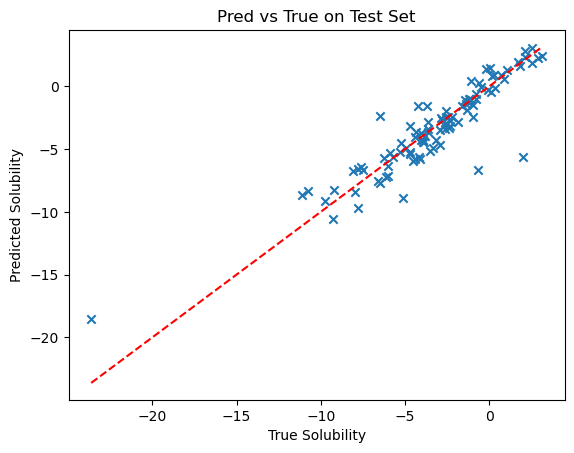

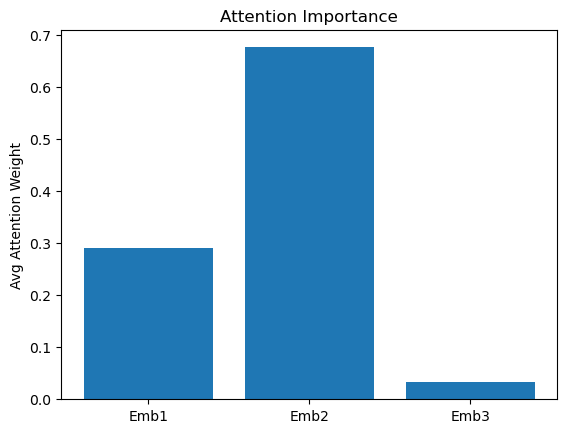

In [14]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Train')
plt.plot(range(1, epochs+1), val_losses,   marker='s', label='Val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

model.eval()
y_true, y_pred, attn_list = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        preds, weights = model(xb)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        attn_list.append(weights.cpu().numpy())
        test_loss = criterion(torch.tensor(y_pred, device=device), torch.tensor(y_true, device=device))**0.5
        print(f"Test Loss: {test_loss.item():.4f}")
attn = np.vstack(attn_list)

plt.figure()
plt.scatter(y_true, y_pred, marker='x')
mn, mx = min(y_true), max(y_true)
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Pred vs True on Test Set')
plt.show()

avg_weights = attn.mean(axis=0)
plt.figure()
plt.bar(['Emb1','Emb2','Emb3'], avg_weights)
plt.ylabel('Avg Attention Weight')
plt.title('Attention Importance')
plt.show()

In [17]:
class MLP(nn.Module):
    def __init__(self, emb_dim, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out = self.mlp(x).squeeze(-1)
        return out

In [21]:
for xb, yb in train_loader:
    xb = torch.cat([xb[:, i, :] for i in range(xb.size(1))], dim=1)
    print(xb.shape)
    break

torch.Size([32, 384])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim   = embeddings.shape[-1]*3
model     = MLP(emb_dim=emb_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 300
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    total_train = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        xb = torch.cat([xb[:, i, :] for i in range(xb.size(1))], dim=1)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * xb.size(0)
    train_losses.append((total_train / len(train_ds))**0.5)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            preds, _ = model(xb)
            total_val += criterion(preds, yb).item() * xb.size(0)
    val_losses.append((total_val / len(val_ds))**0.5)
    print(f"Epoch {epoch}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

c:\Users\chenxinyi\.conda\envs\torch\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (3) must match the size of tensor b (32) at non-singleton dimension 1